## Bibliotecas

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from google.colab                 import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Storytelling:
Diante da concessão de créditos para clientes, uma empresa da região norte do Brasil deseja automatizar a disponibilidade de crédito para o cliente a partir do Score do cliente. Sabe-se que, o Score real do cliente existe, mas o setor de crédito deseja estimar com base em modelos preditivos o Score do consumidor.


### Objetivo:
* Encontrar o melhor modelo de aprendizado para estimar o Score do consumidor

## Leitura e visualização de dados

In [3]:
df_emprestimos = pd.read_csv('/content/gdrive/MyDrive/Datasets/emprestimos/loan_data.csv')
df_emprestimos.shape

(9578, 14)

In [4]:
df_emprestimos.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [5]:
df_emprestimos.tail()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1
9577,0,debt_consolidation,0.1392,853.43,11.264464,16.28,732,4740.000000,37879,57.0,6,0,0,1


## Features

* **credit.policy** (cirterio de concessão de crédito): 1 - Atende os critérios / 0 - Não atende os critéiros
* **purpose** (finalidade do empréstimo): Atributos categóricos divididos em:
  - Cartão de crédito
  - Concolidação de dívidas
  - Gasto educacional
  - Compra acima do limite
  - Startup (empreendimento)
  - outros
* **int.rate** ( taxa de juros)
* **installment** (parcela mensal): Valor da parcela do empréstimos caso seja concedido
* **log.annual.inc**: Renda anual do usuário
* **dti**: Montante da dívida pelo rendimento anual
* **fico** : Score de crédito
* **days.with.cr.line**: Dias com linha de crédito disponível
* **revol.bal** : Valor não pago no final do ciclo de faturamento do cartão de crédito
* **revol.util** : Montante da linha de crédito utilizada em relação ao crédito total disponível
* **inq.last.6mths** : Consulta de credores nos ultimos 6 meses
* **delinq.2yrs** : O número de vezes que o mutuário esteve com mais de 30 dias de atraso em um pagamento nos últimos 2 anos.
* **pub.rec** : Número de pedidos de falência, ônus fiscais ou sentenças.
* **not.fully.paid** : Se o empréstimo concedido foi totalmente pago ou não



## Regressão linear simples

* Encontrando correlação de Score de clientes com features disponíveis

In [6]:
df_emprestimos

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


Uma das cracaterísticas que iremos tentar prever neste repositório é a relação do Score disponível do usuário vinculado a taxa de juros concedida no empréstimo. Diante disso, buscamos analisar a correlação dessas duas festures, como podemos visualizar abaixo:

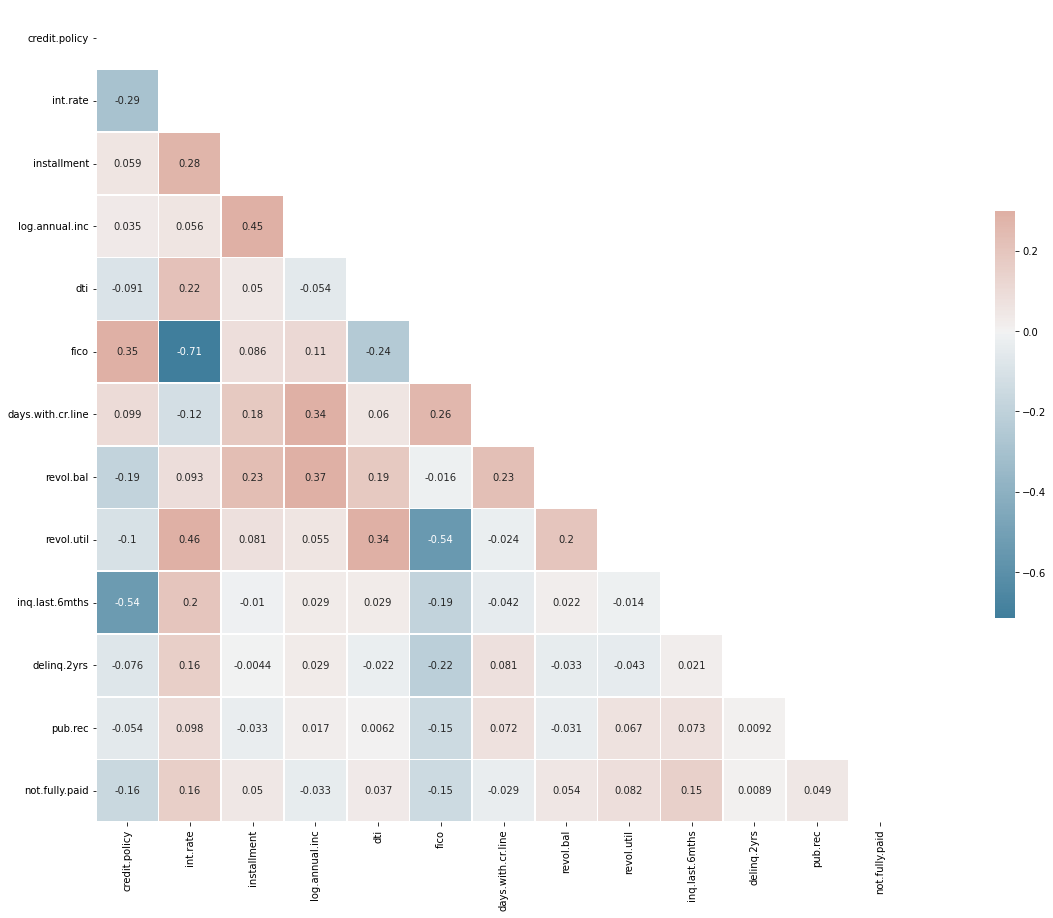

In [7]:
corr = df_emprestimos.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(30, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

### Regressão linear simples

In [11]:
#Separamos as variáveis
X = df_emprestimos['int.rate']
Y = df_emprestimos['fico']

#Adicionaremos um valor constante para que o statsmodels realize o treinamento
X = sm.add_constant(X)

#Criamos o modelo de regressão linear simples
modelo = sm.OLS(Y, X)

#Treinamento
modelo_v1 = modelo.fit()

#Verificamos as variaveis preditas
valores_previstos = modelo_v1.predict(X)

#Adicionamos os dados previstos em um Dataframe para compararmos o Score real e o Score dado pelo modelo
table_preview = df_emprestimos[['int.rate','fico']]
table_preview['predict'] = valores_previstos

In [20]:
table_preview.head(11)

,int.rate,fico,predict
0,0.1189,737,714.627491
1,0.1071,707,726.557214
2,0.1357,682,697.642801
3,0.1008,712,732.926473
4,0.1426,667,690.666946
5,0.0788,727,755.168329
6,0.1496,667,683.589992
7,0.1114,722,722.209942
8,0.1134,682,720.187955
9,0.1221,707,711.392312


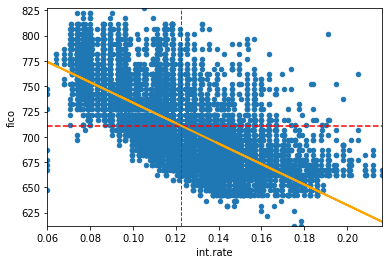

In [30]:
x_range = [df_emprestimos['int.rate'].min(), df_emprestimos['int.rate'].max()]
y_range = [df_emprestimos['fico'].min(), df_emprestimos['fico'].max()]



scatter_plot = df_emprestimos.plot(kind='scatter', x = 'int.rate', y = 'fico', xlim = x_range, ylim = y_range)

meanY = scatter_plot.plot(x_range, [df_emprestimos['fico'].mean(), df_emprestimos['fico'].mean()], '--', color='red')
meanX = scatter_plot.plot([df_emprestimos['int.rate'].mean(), df_emprestimos['int.rate'].mean()], y_range, '--', color = 'red', linewidth = 1)

linha = scatter_plot.plot(df_emprestimos['int.rate'], valores_previstos, '-', color='orange', linewidth = 2)